# GIMVI analysis

Supplemental analysis showing limited generalization of TISSUE to the gimVI model (currently, does not generally work on all datasets due to exploding gradients bug in gimVI).

It relies on the outputs of `spatial_conformal_uncertainty.py` followed by `get_calibration.py` and also `get_score_for_dataset.py` applied to Dataset11 (only dataset that works with gimVI as of August 2023). In particular, it requires running the Python commands in `run_conformal_11_gimvi.slurm` and `run_scores_11_gimvi.slurm`. The h5ad anndata objects and pickle files should be saved into "scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/" with respect to the current working directory (or an alternative path for stratified grouping results).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
from scipy.stats import pearsonr, spearmanr
import anndata as ad
import seaborn as sns
import pickle

from decimal import Decimal
from statsmodels.stats.multitest import multipletests

from TISSUE.tissue.main import *
from TISSUE.tissue.experiments import measure_calibration_error
from TISSUE.tissue.downstream import *
from TISSUE.tissue.utils import *

from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#### Swap dataset names to real identifiers
dataset_mapper = {"Dataset3": "Mouse Hipp.\n(seqFISH)",
                  "Dataset9": "Mouse VISP\n(MERFISH)",
                  "Dataset11": "Mouse PC\n(STARmap)", 
                  "Dataset12": "Human MTG\n(ISS)",
                  "Dataset13": "Mouse VISP\n(ISS)",
                  "Dataset14": "Drosophila Embryo\n(FISH)",
                  "Dataset15": "Mouse SC\n(osmFISH)",
                  "Dataset17": "Mouse VISP\n(ExSeq)",
                  "Axolotl": "Axolotl Brain\n(Stereo-seq)",
                  "Dataset7": "Human U2OS\n(MERFISH)",
                  "Dataset1": "Mouse Gast.\n(seqFISH)",
                  "SVZsubambiguous": "Mouse SVZ\n(MERFISH)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}

label_mapper = {'Dataset3celltype': "Mouse Hipp. (seqFISH) - Cell type",
                'Dataset13celltype_lowres': "Mouse VISP (ISS) - Cell type",
                'Dataset14region': "Drosophila Embryo (FISH) - Region",
                'Dataset15ClusterName': "Mouse SC (osmFISH) - Cell type",
                'Dataset15Region': "Mouse SC (osmFISH) - Region",
                'Dataset1celltype_mapped_refined': "Mouse Gast. (seqFISH) - Cell type",
                'AxolotlAnnotation': "Axolotl Brain (Stereo-seq) - Cell type"}
#### 

## gimVI prediction performance

Collecting prediction performance metrics for one dataset using the output h5ad of `spatial_conformal_uncertainty.py` with gimVI set to the model (requires GPU) followed by `get_calibration.py`.

In [7]:
datasets = ["Dataset11","Dataset14","Dataset1","Dataset7","Axolotl"]
methods = ['gimvi']

dataset_col = []
method_col = []
R_col = []
Spearman_col = []
MAE_col = []


for d in datasets:
    # read results
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_SCPI")
        
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    # loop methods
    for method in methods:
        
        imputed = np.array(adata.obsm[method+"_predicted_expression"])
        actual = adata[:,adata.obsm[method+"_predicted_expression"].columns].X
        
        # loop genes
        for j in range(adata.obsm[method+"_predicted_expression"].shape[1]):
            not_nans = (~np.isnan(imputed[:,j]) & ~np.isnan(actual[:,j]))
            
            # compute stats
            r, p = pearsonr(imputed[not_nans,j], actual[not_nans,j])
            rho, p = spearmanr(imputed[:,j], actual[:,j])
            mae = np.nanmean(np.abs(imputed[:,j]-actual[:,j]))
            
            name = dataset_mapper[d]
            
            # append stats
            dataset_col.append(name+f"\nn={n_cells}\np={n_genes}") # add n_cell/n_gene info
            method_col.append(method_mapper[method])
            R_col.append(r)
            Spearman_col.append(rho)
            MAE_col.append(mae)

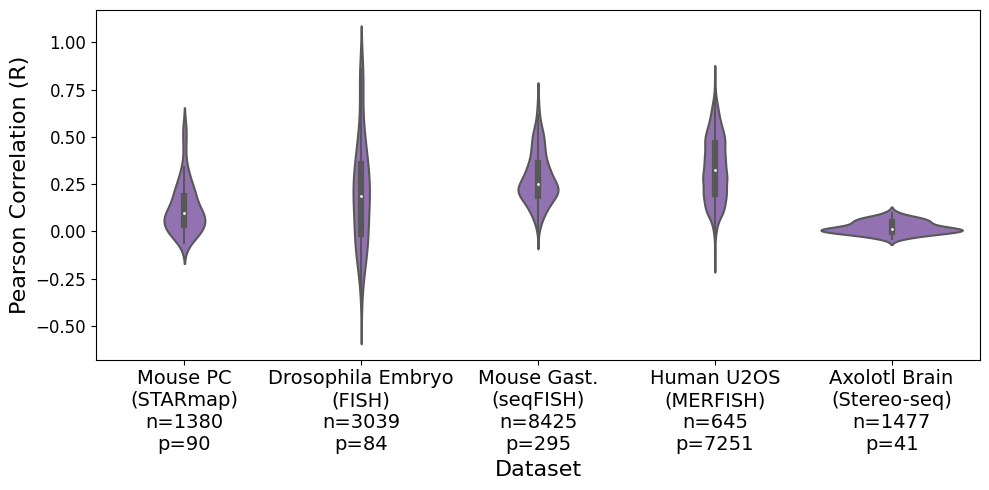

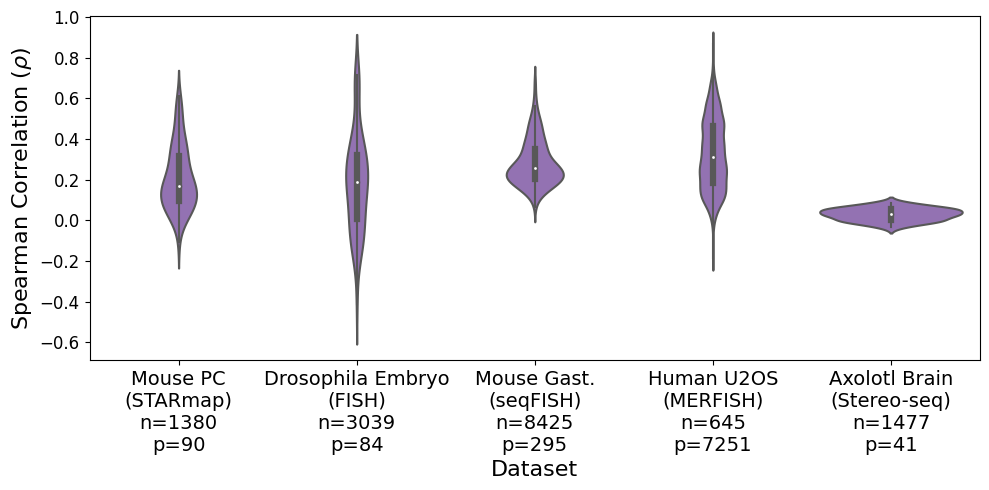

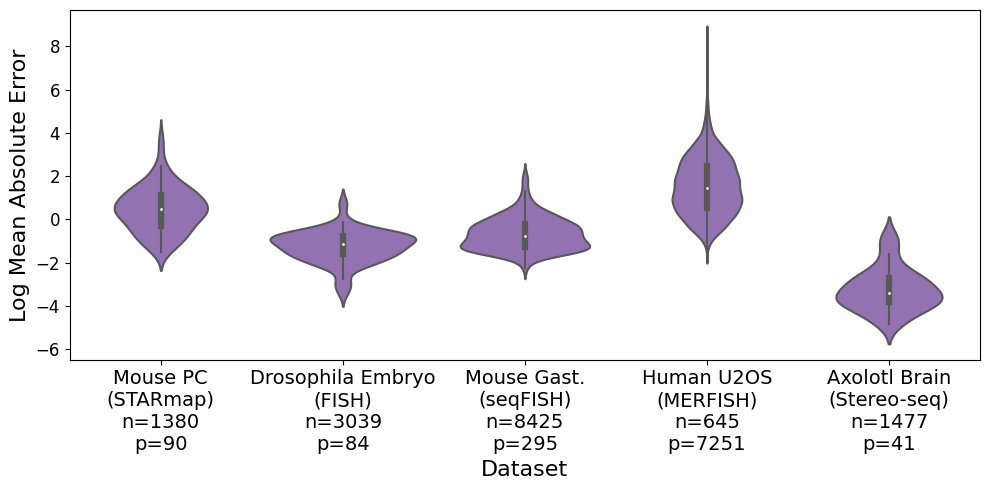

In [8]:
# Generate violin plots of Spearman, Pearson, and MAE performance metrics

# Initialize dataframe
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Pearson"] = R_col
df["Spearman"] = Spearman_col
df["MAE"] = MAE_col
df["MAE"] = df["MAE"].astype(float)
df["log MAE"] = np.log(df["MAE"])


# Pearson
plt.figure(figsize=(10,5))
sns.violinplot(x="Dataset", y="Pearson", color="tab:purple", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Pearson Correlation (R)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/GIMVI_violin_performance_pearson.pdf', dpi=300, bbox_inches='tight')
plt.show()


# Spearman
plt.figure(figsize=(10,5))
sns.violinplot(x="Dataset", y="Spearman", color="tab:purple", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel(r"Spearman Correlation ($\rho$)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/GIMVI_violin_performance_spearman.pdf', dpi=300, bbox_inches='tight')
plt.show()


# MAE
plt.figure(figsize=(10,5))
sns.violinplot(x="Dataset", y="log MAE", color="tab:purple", data=df)
plt.xlabel("Dataset", fontsize=16)
plt.ylabel("Log Mean Absolute Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('plots/scpi_datasets/GIMVI_violin_performance_logmae.pdf', dpi=300, bbox_inches='tight')
plt.show()

## TISSUE calibration performance

Collecting calibration performance from pickel file output of `get_calibration.py`

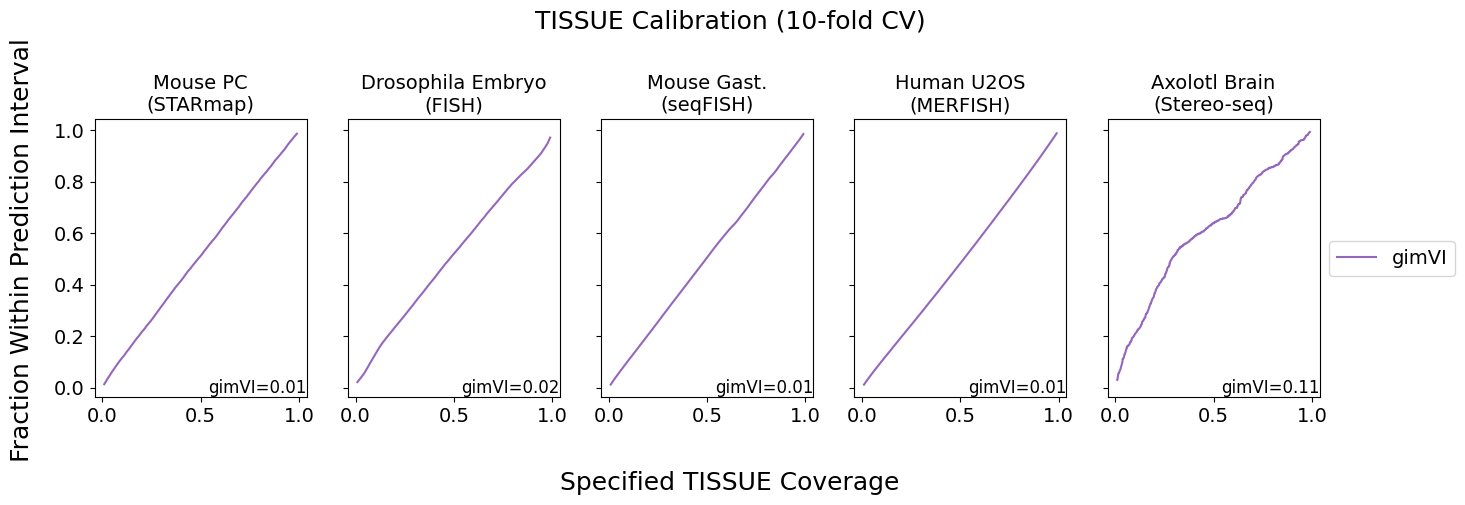

In [9]:
# Generate calibration plot for all genes averaged together
dataset_names = ["Dataset11","Dataset14","Dataset1","Dataset7","Axolotl"]
colors = ["tab:purple"]

fig, axs = plt.subplots(nrows=1, ncols=len(dataset_names), sharex=True, sharey=True, figsize=(15, 5))
for i, dataset_name in enumerate(dataset_names):
    pickleFile = open("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+dataset_name+"_conformal_dict_gimvi.pkl", 'rb')
    res_dict = pickle.load(pickleFile)

    for ki, key in enumerate(res_dict.keys()):
        axs[i].plot(res_dict[key]['1-alpha'], res_dict[key]['test'], linewidth=1.5, label=method_mapper[key], color=colors[ki])
        error = round(measure_calibration_error(res_dict, key),2)
        axs[i].annotate(method_mapper[key]+"="+str(error), xy=(1, 0+(ki*0.05)), xycoords='axes fraction', fontsize=12, horizontalalignment='right', verticalalignment='bottom')
    
    axs[i].set_title(dataset_mapper[dataset_name], fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].tick_params(axis='both', which='minor', labelsize=14)
    
fig.suptitle("TISSUE Calibration (10-fold CV)", fontsize=18)
fig.supxlabel("Specified TISSUE Coverage", fontsize=18)
fig.supylabel("Fraction Within Prediction Interval", fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/scpi_calibration/GIMVI_REVISED_paneled_AVG_calibration_curves.pdf')
plt.show()

## Correlation between gimVI error and cell-centric variability

0.7014906501113715
0.6207455145948015


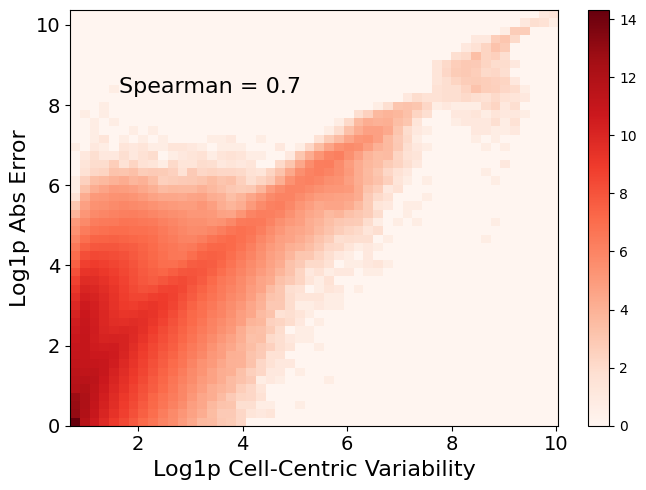

In [11]:
# combined into one plot

datasets = ["Dataset11","Dataset14","Dataset1","Dataset7","Axolotl"]
methods = ['gimvi']


dataset_col = []
method_col = []
uncertainty_col = []
abs_error_col = []


for i, d in enumerate(datasets):
    
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_NOCV.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_NOCV.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_NOCV")
    
    n_cells = adata.shape[0]
    n_genes = adata.shape[1]
    
    for j, method in enumerate(methods):
        
        # get uncertainties, errors matched
        genes = adata.var_names
        uncertainties = adata.obsm[method+"_predicted_expression_uncertainty"][genes]
        errs = np.abs(adata.obsm[method+"_predicted_expression"][genes]-adata.X)
        uncertainties = np.array(uncertainties).flatten()
        errs = np.array(errs).flatten()
        
        # append results
        dataset_col.append([d]*len(uncertainties))
        method_col.append([method]*len(uncertainties))
        uncertainty_col.append(uncertainties)
        abs_error_col.append(errs)

        
dataset_col = np.concatenate(dataset_col)
method_col = np.concatenate(method_col)
uncertainty_col = np.concatenate(uncertainty_col)
abs_error_col = np.concatenate(abs_error_col)

# Make dataframe
df = pd.DataFrame([])
df["Dataset"] = dataset_col
df["Method"] = method_col
df["Error"] = abs_error_col
df["Uncertainty"] = uncertainty_col


# Make Plot
x = np.log1p(df["Uncertainty"])
y = np.log1p(df["Error"])

rho, p = spearmanr(x, y)
r, p = pearsonr(x, y)
print(rho)
print(r)

plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.xlabel("Log1p Cell-Centric Variability", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f'plots/scpi_datasets/GIMVI_REVISED_uncertainty_error_correlations_log_COMBINED.pdf', bbox_inches='tight')
plt.show()

## Correlation between gimVI error and TISSUE PI width

0.7186387174170107
0.6893808333662307


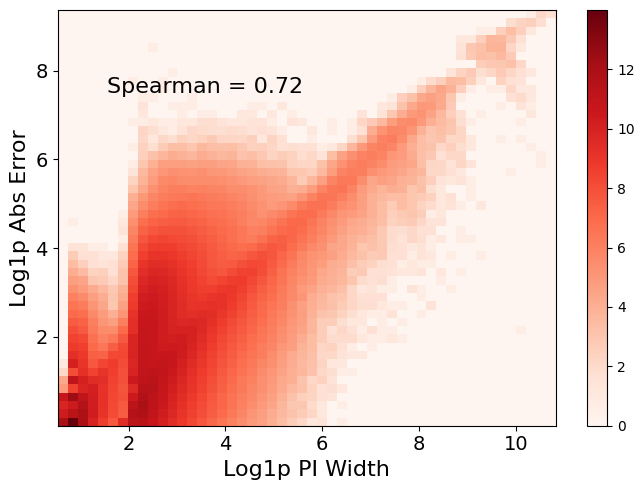

In [12]:
# CELL x GENE level

pi_width = 67

methods = ['gimvi']
datasets = ["Dataset11","Dataset14","Dataset1","Dataset7","Axolotl"]


all_uppers = np.array([])
all_lowers = np.array([])
all_predicteds = np.array([])
all_maes = np.array([])
all_datasets = np.array([])
all_models = np.array([])

for d in datasets:
    
    # read results
    if os.path.isfile("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_SCPI.h5ad"):
        adata = sc.read_h5ad("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_SCPI.h5ad")
    else:
        adata = large_load("scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/"+d+"_gimvi_SCPI")
    
    # compute stacked bandwidth matrices and stacked prediction matrices

    stacked_uppers = []
    stacked_lowers = []
    stacked_predicteds = []
    stacked_maes = []
    stacked_datasets = []
    stacked_models = []
    
    for i, method in enumerate(methods):
        stacked_uppers.append(adata.obsm[method+f"_predicted_expression_hi_{pi_width}"].values)
        stacked_lowers.append(adata.obsm[method+f"_predicted_expression_lo_{pi_width}"].values)
        stacked_predicteds.append(adata.obsm[method+"_predicted_expression"].values)
        stacked_maes.append(np.abs(adata.obsm[method+"_predicted_expression"].values-adata[:,adata.obsm[method+"_predicted_expression"].columns].X))
        stacked_datasets.append(np.full(adata.obsm[method+"_predicted_expression"].shape, d))
        stacked_models.append(np.full(adata.obsm[method+"_predicted_expression"].shape, method))
        
        use_cols = adata.obsm[method+"_predicted_expression"].columns
        use_rows = adata.obsm[method+"_predicted_expression"].index
    
    # append flattened versions
    all_uppers = np.concatenate([all_uppers]+[x.flatten() for x in stacked_uppers])
    all_lowers = np.concatenate([all_lowers]+[x.flatten() for x in stacked_lowers])
    all_predicteds = np.concatenate([all_predicteds]+[x.flatten() for x in stacked_predicteds])
    all_maes = np.concatenate([all_maes]+[x.flatten() for x in stacked_maes])
    all_datasets = np.concatenate([all_datasets]+[x.flatten() for x in stacked_datasets])
    all_models = np.concatenate([all_models]+[x.flatten() for x in stacked_models])
    
# Make Plot
rho, p = spearmanr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
r, p = pearsonr(np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)])
print(rho)
print(r)

plt.figure(figsize=(7,5))
heatmap, xedges, yedges = np.histogram2d(
    np.log1p(all_uppers-all_lowers)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            np.log1p(all_maes)[(all_predicteds>0)&np.isfinite(all_predicteds)&~np.isnan(all_uppers-all_lowers)],
            bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(np.log1p(heatmap).T, extent=extent, origin='lower', cmap='Reds', aspect='auto')
plt.annotate("Spearman = "+str(round(rho,2)), (0.1,0.8), xycoords="axes fraction", fontsize=16)
plt.colorbar()
plt.xlabel("Log1p PI Width", fontsize=16)
plt.ylabel("Log1p Abs Error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('plots/scpi_exploratory/GIMVI_REVISED_all_CI_vs_AE_newest_kautokauto.pdf', dpi=300, bbox_inches='tight')
plt.show()

## TISSUE differential gene expression analysis (FDR comparison)

In [8]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset14","Dataset1","Axolotl"]
conditions = ["region", "celltype_mapped_refined", "Annotation"]


##################
combined_stat_result_dict = {}

# loop datasets
for i in range(len(dataset_names)):
    
    # get condition and dataset name
    condition=conditions[i]
    dataset_name=dataset_names[i]
    
    # read result anndata object
    adata = sc.read_h5ad(f'scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/{dataset_name}_gimvi_MI_TTEST.h5ad')
    
    # add key to dictionary for dataset
    combined_stat_result_dict[dataset_name] = {}
    
    # loop methods
    for method in ["gimvi"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}

        for g1 in np.unique(adata.obs[condition]):
            
            # define groups
            key = str(g1)+"_all"
            g1_bool = (adata.obs[condition] == g1) # g1
            g2_bool = (adata.obs[condition] != g1) # all other
            
            # add new entries to dictionary
            combined_stat_result_dict[dataset_name][method][key] = {}
            combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values

            # add TISSUE t-test results from adata.var
            var_key = method+"_"+key
            combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_tstat"] = adata.var[var_key+"_tstat"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varw"] = adata.var[var_key+"_varw"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_varb"] = adata.var[var_key+"_varb"].values
            combined_stat_result_dict[dataset_name][method][key]["mi_poolmean"] = adata.var[var_key+"_poolmean"].values

            # t-test for true/measured values
            tt, pp = two_sample_ttest(adata.X, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["true_tstat"] = tt

            # t-test for predicted/imputed values
            tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][adata.var_names].values, g1_bool, g2_bool)
            combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp
            combined_stat_result_dict[dataset_name][method][key]["imp_tstat"] = tt

# # pickle dict
# with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_gimvi.pkl", "wb") as f:
#     pickle.dump(combined_stat_result_dict, f)

/tmp/ipykernel_167/4128976593.py:66: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_167/4128976593.py:67: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


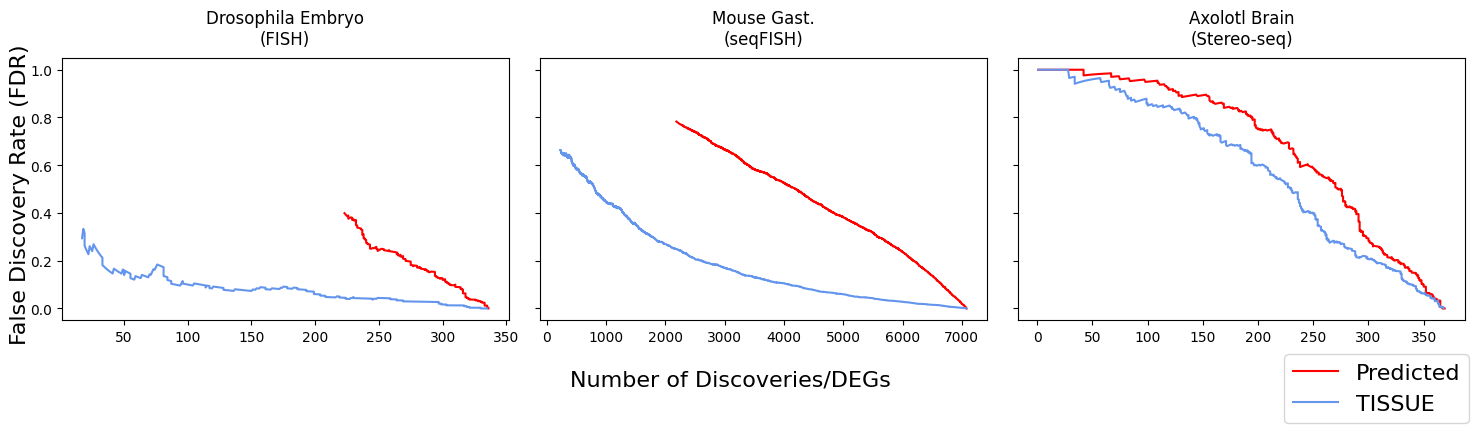

In [3]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset14","Dataset1","Axolotl"]
methods = ["gimvi"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_gimvi.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(15,4), sharex=False, sharey=True)
    
    
# loop dataset and method to make a panel for each combo    
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        # Number of discoveries
        num_pos_1 = []
        num_pos_2 = []
        
        # FDR for predicted (baseline) and TISSUE MI
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR statistic
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        # generate plot panel
        axs[j].plot(num_pos_1, fdr_list_1, color='r', label="Predicted")
        axs[j].plot(num_pos_2, fdr_list_2, color='cornflowerblue', label="TISSUE")

# legend
fig.legend(["Predicted", "TISSUE"], loc='lower right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
cols = [dataset_mapper[d] for d in list(dataset_names)]
rows = [method_mapper[m] for m in list(methods)]
padrow = 5
padcol = 10
for ax, col in zip(axs, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/GIMVI_paneled_pvalue_numpositives_fdr_curves.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# For printing out values for Supplementary Table 2

dataset_names = ["Dataset14","Dataset1","Axolotl"]
methods = ["gimvi"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

proportion_discoveries = 0.4

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_gimvi.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(15,5), sharex=False, sharey=True)
    
    
# loop dataset and method to make a panel for each combo    
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        # Number of discoveries
        num_pos_1 = []
        num_pos_2 = []
        
        # FDR for predicted (baseline) and TISSUE MI
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR statistic
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        # threshold to report FDR for
        cut_idx1 = (np.abs(np.array(num_pos_1)-round(len(agg_x)*proportion_discoveries))).argmin()
        cut_idx2 = (np.abs(np.array(num_pos_2)-round(len(agg_x)*proportion_discoveries))).argmin()
        print(dataset)
        print(method)
        print(fdr_list_2[cut_idx2])
        print(fdr_list_1[cut_idx1])
        print("")

## TISSUE Cell Filtering for clustering/visualization/prediction

In [39]:
# Set up experiment parameters
experiment_name = "GIMVI"
dirnames = ["2023Aug1_k4k1_SDbasedCCPplus1"]
dataset_names = ["Dataset14", "Dataset1", "Axolotl"]
metadata_labels = ["region", "celltype_mapped_refined", "Annotation"]
methods = ['gimvi']
n_classes = 3
filter_proportion = "otsu"


######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Directory"] = []
df_dict["Label"] = []
df_dict["Imputation Method"] = []
df_dict["Approach"] = []

df_dict["Accuracy"] = []
df_dict["F1"] = []
df_dict["ROC_AUC"] = []
df_dict["ARI"] = []
df_dict["Separability"] = []

for dirname in dirnames:
    for di, d in enumerate(dataset_names):
        
        label = metadata_labels[di]
        
        adata = sc.read_h5ad(f"scg_results/scpi/{dirname}/{d}_gimvi_SCPI.h5ad")

        # subset into observations falling into most prevalent classes (if specified)
        uniq_labels, counts = np.unique(adata.obs[label], return_counts=True)
        if len(uniq_labels) > n_classes:
            sorted_uniq_labels = uniq_labels[np.argsort(counts)][::-1][:n_classes]
            adata = adata[adata.obs[label].isin(sorted_uniq_labels)]

        for m in methods:
            
            predicted = f'{m}_predicted_expression'
            
            # get prediction intervals
            adata.obsm[f'{predicted}_hi'] = adata.obsm[f'{predicted}_hi_67']
            adata.obsm[f'{predicted}_lo'] = adata.obsm[f'{predicted}_lo_67']
            
            ######################################################
            # Predictive modeling (classification evaluation)
            ######################################################
            
            # Imputed - Uncertainty
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            splits = kf.split(X, adata.obs[label])
            unc_acc = []
            unc_f1 = []
            unc_roc_auc = []
            for i, (train_index, test_index) in enumerate(splits):
                # get train test
                X_train = X[train_index,:].copy()
                X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
                y_train = adata.obs[label].values[train_index]
                X_test = X[test_index,:].copy()
                X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
                y_test = adata.obs[label].values[test_index]
                # filter both independently
                keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
                keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
                # fit model
                model = LogisticRegression(penalty='l1', solver='liblinear')
                scaler = StandardScaler()
                X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
                model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
                # evaluate
                pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
                pred_y_test_scores = model.predict_proba(scaler.transform(X_test[keep_idxs_test,:]))
                unc_acc.append(accuracy_score(y_test[keep_idxs_test], pred_y_test))
                unc_f1.append(f1_score(y_test[keep_idxs_test], pred_y_test, average='macro'))
                unc_roc_auc.append(roc_auc_score(y_test[keep_idxs_test], pred_y_test_scores, multi_class='ovr'))

            unc_acc = np.mean(unc_acc)
            unc_f1 = np.mean(unc_f1)
            unc_roc_auc = np.mean(unc_roc_auc)

            # Imputed
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            X = StandardScaler().fit_transform(X)
            imp_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            imp_acc = imp_dict['test_accuracy'].mean()
            imp_f1 = imp_dict['test_f1_macro'].mean()
            imp_roc_auc = imp_dict['test_roc_auc_ovr'].mean()

            # Measured
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.X
            X = StandardScaler().fit_transform(X)
            measured_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            measured_acc = measured_dict['test_accuracy'].mean()
            measured_f1 = measured_dict['test_f1_macro'].mean()
            measured_roc_auc = measured_dict['test_roc_auc_ovr'].mean()
            
            
            ##### Set up data for CLUSTERING and VISUALIZATION
            labels = adata.obs[label].values.copy()
            
            # Imputed - Uncertainty
            unc_keep_idxs = filtered_PCA(adata, m, proportion=filter_proportion, stratification=labels,
                                         return_keep_idxs=True)
            #print(len(unc_keep_idxs)/adata.shape[0])
            X_red_imp_unc_fil = adata.uns[predicted+'_PC15_filtered_'].copy()

            # Imputed
            filtered_PCA(adata, m, proportion=0, stratification=labels)
            X_red_imp = adata.obsm[predicted+'_PC15_'].copy()

            # Measured
            X = adata.X
            X = StandardScaler().fit_transform(X)
            X_red_measured = PCA(n_components=15).fit_transform(X)
            
            
            ######################################################
            # Clustering (ARI)
            ######################################################
            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp_unc_fil)
            clusters = kmeans.labels_
            unc_fil_ari = adjusted_rand_score(labels[unc_keep_idxs], clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp)
            clusters = kmeans.labels_
            imp_ari = adjusted_rand_score(labels, clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_measured)
            clusters = kmeans.labels_
            measured_ari = adjusted_rand_score(labels, clusters)
    
            
            ######################################################
            # Visualization (Linear Separability)
            ######################################################

            #### Linear separability
            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_unc_fil, labels[unc_keep_idxs])
            unc_fil_sep = clf.score(X_red_imp_unc_fil, labels[unc_keep_idxs])

            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp, labels)
            imp_sep = clf.score(X_red_imp, labels)

            clf = SVC(kernel='linear', random_state=444).fit(X_red_measured, labels)
            measured_sep = clf.score(X_red_measured, labels)
            
            
            # Append results to dictionary
            df_dict["Dataset"] += [d,d,d]
            df_dict["Label"] += [label, label, label]
            df_dict["Directory"] += [dirname, dirname, dirname]
            df_dict["Imputation Method"] += [m,m,m]
            df_dict["Approach"] += ["Imputed", "Imputed-Uncertainty", "Measured"]
            df_dict["Accuracy"] += [imp_acc, unc_acc, measured_acc]
            df_dict["F1"] += [imp_f1, unc_f1, measured_f1]
            df_dict["ROC_AUC"] += [imp_roc_auc, unc_roc_auc, measured_roc_auc]
            df_dict["ARI"] += [imp_ari, unc_fil_ari, measured_ari]
            df_dict["Separability"] += [imp_sep, unc_fil_sep, measured_sep]

/tmp/ipykernel_90/2942222708.py:45: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm[f'{predicted}_hi'] = adata.obsm[f'{predicted}_hi_67']
/tmp/ipykernel_90/2942222708.py:45: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obsm[f'{predicted}_hi'] = adata.obsm[f'{predicted}_hi_67']
/tmp/ipykernel_90/2942222708.py:45: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.obs

In [40]:
# # uncomment to save results
# with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "wb") as f:
#     pickle.dump(df_dict, f)

In [5]:
# load dictionary of results from pickle file
experiment_name = "GIMVI"
n_classes = 3

with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "rb") as f:
    df_dict = pickle.load(f)

In [6]:
dataset_labels = ['Dataset14region','Dataset1celltype_mapped_refined',
                  'AxolotlAnnotation']
metrics = ["Accuracy", "F1", "ROC_AUC", "ARI", "Separability"]
directories = ["2023Aug1_k4k1_SDbasedCCPplus1"]

########### Make Heatmap plot

df = pd.DataFrame(df_dict)
df["Dataset_Label"] = df["Dataset"] + df["Label"]

df = df[df["Directory"].isin(directories)].copy()

# init heatmap values
log2FC = np.zeros((len(dataset_labels),len(metrics)))
avg_improvement = np.zeros((len(dataset_labels),len(metrics)))
paired_ttest_pvalue = np.ones((len(dataset_labels),len(metrics)))

for j, metric in enumerate(metrics):
    
    # outdated code to adjust for old formatting
    if "Imputed-Uncertainty-Filtered" in df["Approach"].values:
        if metric in ["Accuracy", "F1", "ROC_AUC"]:
            tissue_key = "Imputed-Uncertainty"
        else:
            tissue_key = "Imputed-Uncertainty-Filtered"
    else:
        tissue_key = "Imputed-Uncertainty"
    
    # generate statistics (fold change and p-value)
    for i, dl in enumerate(dataset_labels):
        
        subdf = df[df["Dataset_Label"]==dl].copy()
        
        # statistical significance
        t,p = ttest_rel(subdf[subdf["Approach"]=="Imputed"][metric], subdf[subdf["Approach"]==tissue_key][metric])
        paired_ttest_pvalue[i,j] = p
        
        # effect size
        avglogfc = np.log2(np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) / np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric]))
        log2FC[i,j] = avglogfc
        avg_improvement[i,j] = np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) - np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric])

/tmp/ipykernel_167/1876575870.py:35: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = ttest_rel(subdf[subdf["Approach"]=="Imputed"][metric], subdf[subdf["Approach"]==tissue_key][metric])
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


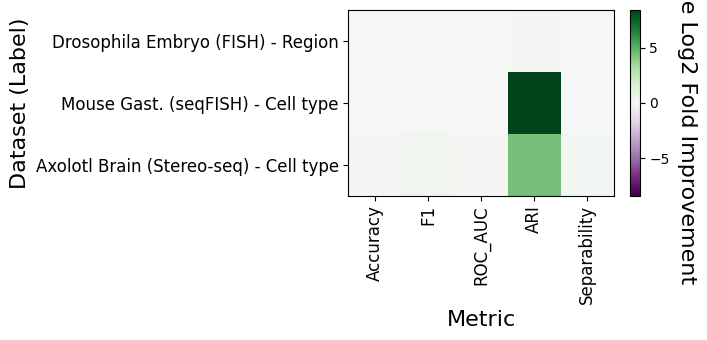

In [64]:
p = 0.05 # cutoff

xticklabels = metrics
yticklabels = [label_mapper[x] for x in dataset_labels]

# make mask with * for significant improvements
sig_mask = paired_ttest_pvalue.copy().astype(str)
sig_mask[paired_ttest_pvalue < p] = "*"
sig_mask[sig_mask != "*"] = ""

# make heatmap and overlay significance
plt.figure(figsize=(7,3.5))
maxlim = np.max(np.abs(log2FC))
plt.imshow(log2FC, aspect='auto', cmap="PRGn", vmin=-maxlim, vmax=maxlim)
plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Average Log2 Fold Improvement', rotation=270, fontsize=16, labelpad=20)
for i in range(len(yticklabels)):
    for j in range(len(xticklabels)):
        text = plt.text(j, i, sig_mask[i, j],
                       ha="center", va="center", color="k", fontsize=20)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Dataset (Label)", fontsize=16)
plt.tight_layout()
dir_tag = "_".join(directories)
metrics_tag = "_".join(metrics)
plt.savefig(f"plots/scpi_prediction/GIMVI_heatmap_{dir_tag}__{metrics_tag}.pdf", bbox_inches="tight")
plt.show()

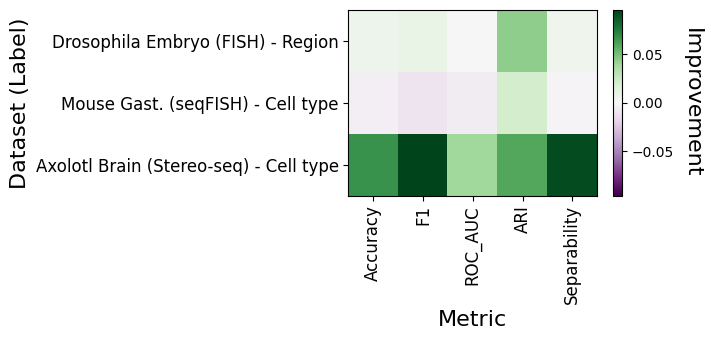

In [65]:
p = 0.05 # cutoff

xticklabels = metrics
yticklabels = [label_mapper[x] for x in dataset_labels]

# make mask with * for significant improvements
sig_mask = paired_ttest_pvalue.copy().astype(str)
sig_mask[paired_ttest_pvalue < p] = "*"
sig_mask[sig_mask != "*"] = ""

# make heatmap and overlay significance
plt.figure(figsize=(7,3.5))
maxlim = np.max(np.abs(avg_improvement))
plt.imshow(avg_improvement, aspect='auto', cmap="PRGn", vmin=-maxlim, vmax=maxlim)
plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Improvement', rotation=270, fontsize=16, labelpad=20)
for i in range(len(yticklabels)):
    for j in range(len(xticklabels)):
        text = plt.text(j, i, sig_mask[i, j],
                       ha="center", va="center", color="k", fontsize=20)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Dataset (Label)", fontsize=16)
plt.tight_layout()
dir_tag = "_".join(directories)
metrics_tag = "_".join(metrics)
plt.savefig(f"plots/scpi_prediction/GIMVI_heatmap_{dir_tag}_{metrics_tag}_avgimprovement.pdf", bbox_inches="tight")
plt.show()

## NSC lineage subtype identification (SVZ MERFISH dataset)

In [3]:
# Generate dictionary of results from the AnnData objects

condition="celltype"

# read in result anndata
adata = sc.read_h5ad(f'scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/SVZsubambiguous_gimvi_MI_EXTERNAL_TTEST.h5ad')

# init dict for stats
combined_stat_result_dict = {}

method = "gimvi"

# init subdict
combined_stat_result_dict[method] = {}

group1 = np.unique(adata.obs[condition])

# loop through each comparison group
for g1 in group1:

    key = str(g1)+"_all"
    var_key = method+"_"+key
    g1_bool = (adata.obs[condition] == g1) # g1
    g2_bool = (adata.obs[condition] != g1) # all other

    combined_stat_result_dict[method][key] = {}
    combined_stat_result_dict[method][key]["gene"] = adata.uns[var_key+"_pvalue"].columns

    # add TISSUE statistics from uns
    combined_stat_result_dict[method][key]["mi_pvalue"] = adata.uns[var_key+"_pvalue"].values
    combined_stat_result_dict[method][key]["mi_tstat"] = adata.uns[var_key+"_tstat"].values

    # compute baseline statistics
    tt, pp = two_sample_ttest(adata.obsm[method+"_predicted_expression"][combined_stat_result_dict[method][key]["gene"]].values,
                              g1_bool, g2_bool)
    combined_stat_result_dict[method][key]["imp_pvalue"] = pp
    combined_stat_result_dict[method][key]["imp_tstat"] = tt

# pickle dict
with open(f"results/hypothesis_testing/SVZmerfish_subambiguous_external_gimvi.pkl", "wb") as f:
    pickle.dump(combined_stat_result_dict, f)

In [4]:
with open(f"results/hypothesis_testing/SVZmerfish_subambiguous_external_gimvi.pkl", "rb") as f:
    combined_stat_result_dict = pickle.load(f)

In [6]:
# compile TISSUE MI t-test statistics
target_genes = np.genfromtxt("../SpatialAging/pilot_data_analysis/tissue_results/lineage_marker_genes.txt", dtype=str)

group_col = []
method_col = []
gene_col = []
tstat_diff_col = []
tstat_mi_col = []
tstat_imp_col = []
pval_diff_col = []
p_val_imp = []
p_val_mi = []

method = "gimvi"
for group1 in combined_stat_result_dict[method].keys():

    # subset genes
    genes = combined_stat_result_dict[method][group1]["gene"]
    target_bools = np.isin(genes, target_genes)

    # compute diffs
    diffs = np.abs(combined_stat_result_dict[method][group1]["mi_tstat"]-combined_stat_result_dict[method][group1]["imp_tstat"])
    pdiffs = np.abs(combined_stat_result_dict[method][group1]["mi_pvalue"]-combined_stat_result_dict[method][group1]["imp_pvalue"])

    # add results
    method_col.append([method]*np.sum(target_bools))
    group_col.append([group1]*np.sum(target_bools))
    gene_col.append(genes[target_bools])
    tstat_diff_col.append(diffs.flatten()[target_bools])
    tstat_mi_col.append(combined_stat_result_dict[method][group1]["mi_tstat"].flatten()[target_bools])
    tstat_imp_col.append(combined_stat_result_dict[method][group1]["imp_tstat"].flatten()[target_bools])
    pval_diff_col.append(pdiffs.flatten()[target_bools])

    p_val_imp.append(combined_stat_result_dict[method][group1]["imp_pvalue"].flatten()[target_bools])
    p_val_mi.append(combined_stat_result_dict[method][group1]["mi_pvalue"].flatten()[target_bools])

group_col = np.concatenate(group_col)
method_col = np.concatenate(method_col)
gene_col = np.concatenate(gene_col)
tstat_diff_col = np.concatenate(tstat_diff_col)
tstat_mi_col = np.concatenate(tstat_mi_col)
tstat_imp_col = np.concatenate(tstat_imp_col)
pval_diff_col = np.concatenate(pval_diff_col)
p_val_imp = np.concatenate(p_val_imp)
p_val_mi = np.concatenate(p_val_mi)

res_df = pd.DataFrame([])
res_df["group"] = group_col
res_df["gene"] = gene_col
res_df["method"] = method_col
res_df["abs_tstat_diff"] = tstat_diff_col
res_df["tstat_mi"] = tstat_mi_col
res_df["tstat_imp"] = tstat_imp_col
res_df["abs_pval_diff"] = pval_diff_col
res_df["p_val_imp"] = p_val_imp
res_df["p_val_mi"] = p_val_mi

In [7]:
res_df = res_df.loc[res_df["group"].isin(["Ambiguous_1_all",
                                          "Ambiguous_2_all",
                                          "Ambiguous_3_all"]),:]
res_df

,group,gene,method,abs_tstat_diff,tstat_mi,tstat_imp,abs_pval_diff,p_val_imp,p_val_mi
0,Ambiguous_1_all,aqp4,gimvi,5.127156,-5.372366,-10.499522,1.031939e-07,0.000000,1.031939e-07
1,Ambiguous_1_all,aldh1l1,gimvi,7.791218,-3.530671,-11.321888,4.588325e-04,0.000000,4.588325e-04
2,Ambiguous_1_all,prom1,gimvi,8.382640,-2.521734,-10.904374,1.196831e-02,0.000000,1.196831e-02
3,Ambiguous_1_all,slc1a3,gimvi,5.393854,-8.253800,-13.647653,4.440892e-16,0.000000,4.440892e-16
4,Ambiguous_1_all,nr2e1,gimvi,9.556633,-3.150382,-12.707015,1.767339e-03,0.000000,1.767339e-03
...,...,...,...,...,...,...,...,...,...
61,Ambiguous_3_all,stmn2,gimvi,0.232321,-0.271530,-0.503851,1.715624e-01,0.614510,7.860722e-01
62,Ambiguous_3_all,dlx6os1,gimvi,0.775473,-0.408781,-1.184254,4.461974e-01,0.236677,6.828744e-01
63,Ambiguous_3_all,igfbpl1,gimvi,0.755943,-0.381998,-1.137941,4.470800e-01,0.255498,7.025782e-01
64,Ambiguous_3_all,sox11,gimvi,0.565968,0.562651,1.128618,3.144537e-01,0.259410,5.738632e-01


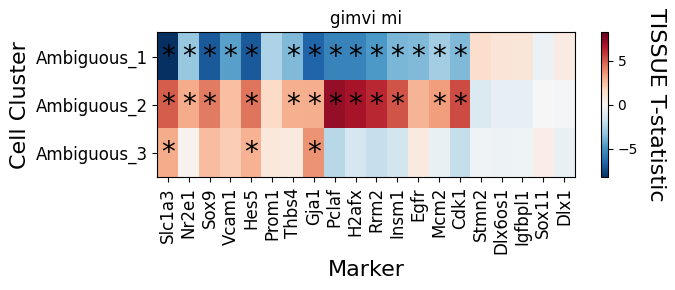

In [9]:
qNSC_astro_markers = ['Slc1a3','Nr2e1','Sox9','Vcam1','Hes5','Prom1',
                     'Thbs4','Gja1']
aNSC_NPC_markers = ['Pclaf', 'H2afx', 'Rrm2', 'Insm1', 'Egfr',
                    'Mcm2', 'Cdk1']
Neuroblast_markers = ['Stmn2', 'Dlx6os1', 'Igfbpl1', 'Sox11','Dlx1']

markers_list = np.concatenate([qNSC_astro_markers,aNSC_NPC_markers,Neuroblast_markers])

p_cutoff = 0.1



##################

method = "gimvi"

subdf = res_df[res_df["method"]==method]
result_rows_mi = []
result_rows_mi_pval = []

# for each group and marker, add the t-stat to the corresponding row
for group in np.unique(res_df['group']):
    groupdf = subdf[subdf["group"] == group]
    group_mi = []
    for marker in markers_list:
        if marker.lower() in np.unique(groupdf['gene']):
            group_mi.append(groupdf[groupdf["gene"]==marker.lower()]["tstat_mi"].values[0])
    result_rows_mi.append(group_mi)


# for each group and marker, add the p-value to the corresponding row
for group in np.unique(res_df['group']):
    groupdf = subdf[subdf["group"] == group]
    group_mi = []
    for marker in markers_list:
        if marker.lower() in np.unique(groupdf['gene']):
            group_mi.append(groupdf[groupdf["gene"]==marker.lower()]["p_val_mi"].values[0])
    result_rows_mi_pval.append(group_mi)


# make heatmap plots of the -log 10 pvalues
xticklabels = [x for x in markers_list if x.lower() in np.unique(subdf['gene'])]
yticklabels = [x.split("_all")[0] for x in np.unique(res_df['group'])]

plt.figure(figsize=(7,3))
plt.title(method+" mi")
maxlim = np.max(np.abs(np.vstack(result_rows_mi)))
plt.imshow(np.vstack(result_rows_mi), aspect='auto', cmap="RdBu_r", vmin=-maxlim, vmax=maxlim)
plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel('TISSUE T-statistic', rotation=270, fontsize=16, labelpad=20)
sig_mask = np.vstack([["*" if x < (p_cutoff/len(xticklabels)) else "" for x in row] for row in result_rows_mi_pval])
for i in range(len(yticklabels)):
    for j in range(len(xticklabels)):
        text = plt.text(j, i, sig_mask[i, j],
                       ha="center", va="center", color="k", fontsize=20)
plt.xlabel("Marker", fontsize=16)
plt.ylabel("Cell Cluster", fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/SVZ/DGEA_celltype_heatmap_MI_{method}.pdf", bbox_inches="tight")
plt.show()

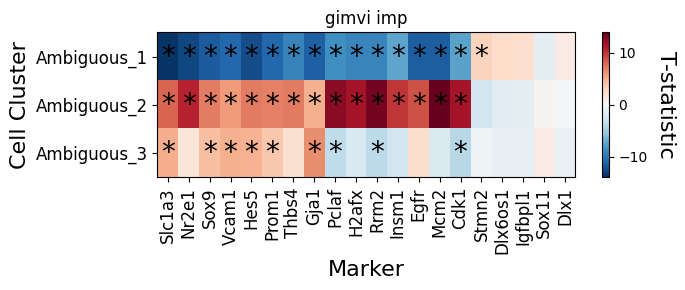

In [11]:
qNSC_astro_markers = ['Slc1a3','Nr2e1','Sox9','Vcam1','Hes5','Prom1',
                     'Thbs4','Gja1']
aNSC_NPC_markers = ['Pclaf', 'H2afx', 'Rrm2', 'Insm1', 'Egfr',
                    'Mcm2', 'Cdk1']
Neuroblast_markers = ['Stmn2', 'Dlx6os1', 'Igfbpl1', 'Sox11','Dlx1']

markers_list = np.concatenate([qNSC_astro_markers,aNSC_NPC_markers,Neuroblast_markers])

p_cutoff = 0.1



##################

method = "gimvi"

subdf = res_df[res_df["method"]==method]
result_rows_mi = []
result_rows_mi_pval = []

# for each group and marker, add the t-stat to the corresponding row
for group in np.unique(res_df['group']):
    groupdf = subdf[subdf["group"] == group]
    group_mi = []
    for marker in markers_list:
        if marker.lower() in np.unique(groupdf['gene']):
            group_mi.append(groupdf[groupdf["gene"]==marker.lower()]["tstat_imp"].values[0])
    result_rows_mi.append(group_mi)


# for each group and marker, add the p-value to the corresponding row
for group in np.unique(res_df['group']):
    groupdf = subdf[subdf["group"] == group]
    group_mi = []
    for marker in markers_list:
        if marker.lower() in np.unique(groupdf['gene']):
            group_mi.append(groupdf[groupdf["gene"]==marker.lower()]["p_val_imp"].values[0])
    result_rows_mi_pval.append(group_mi)


# make heatmap plots of the -log 10 pvalues
xticklabels = [x for x in markers_list if x.lower() in np.unique(subdf['gene'])]
yticklabels = [x.split("_all")[0] for x in np.unique(res_df['group'])]

plt.figure(figsize=(7,3))
plt.title(method+" imp")
maxlim = np.max(np.abs(np.vstack(result_rows_mi)))
plt.imshow(np.vstack(result_rows_mi), aspect='auto', cmap="RdBu_r", vmin=-maxlim, vmax=maxlim)
plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel('T-statistic', rotation=270, fontsize=16, labelpad=20)
sig_mask = np.vstack([["*" if x < (p_cutoff/len(xticklabels)) else "" for x in row] for row in result_rows_mi_pval])
for i in range(len(yticklabels)):
    for j in range(len(xticklabels)):
        text = plt.text(j, i, sig_mask[i, j],
                       ha="center", va="center", color="k", fontsize=20)
plt.xlabel("Marker", fontsize=16)
plt.ylabel("Cell Cluster", fontsize=16)
plt.tight_layout()
plt.savefig(f"plots/SVZ/DGEA_celltype_heatmap_MI_{method}.pdf", bbox_inches="tight")
plt.show()